# Effect of compound kernels on GP fit

This notebook examines the incremental affect of adding more terms to the GP kernel expression, namely Squared Exponential (SE), Matern $\frac{3}{2}$ (M32), and Periodic kernels (P).

There is the possibility of degeneracy between the various hyperparameters of the chosen kernels, especially the overlapping influences on input and output scale parameters ($\ell$ and $\eta$).

Four light curves taken from the ThunderKAT survey have been selected as test cases:
- `80_ra271.352_dec-29.642_MAXIJ1803`: 
- `1817_ra284.905_dec-8.658_J1858TraPDB`
- `428_ra236.530_dec-46.922_4U1543TraPDB`: evenly spaced, no obvious outliers, some correlated noise.
- `502_ra236.310_dec-47.644_4U1543TraPDB`

For a light curve each of the following models is fitted:

1. GP using SE kernel
2. GP using M32 kernel
3. GP using SE + M32 kernel
4. GP using SE $\times$ M32 kernel
5. Sum of SE GP and M32 GP


In [20]:
import math
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import graphviz as gv
import utility_functions as ufn
import importlib
importlib.reload(ufn)

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-white")

RANDOM_SEED = 2023-10-10
rng = np.random.default_rng(RANDOM_SEED)

Running on PyMC v5.6.1


In [2]:
# File paths to CSVs of flux density observations.
csv_paths_list = list(Path('data_raw').iterdir())
csv_paths_list

[PosixPath('data_raw/428_ra236.530_dec-46.922_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/502_ra236.310_dec-47.644_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/1817_ra284.905_dec-8.658_J1858TraPDB_andersson.csv'),
 PosixPath('data_raw/80_ra271.352_dec-29.642_MAXIJ1803TraPDB_andersson.csv')]

# 428_ra236.530_dec-46.922_4U1543

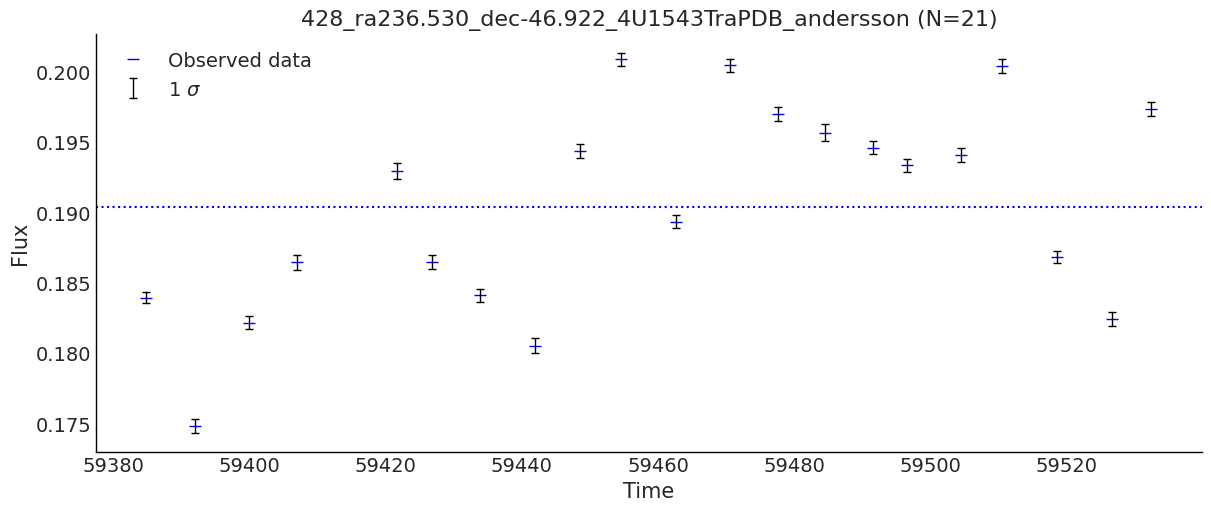

In [3]:
csv_path = csv_paths_list[0]
ufn.plot_lc(csv_path)

## SE Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN},i} \sim \textrm{HalfNormal}(e_i^2)$$

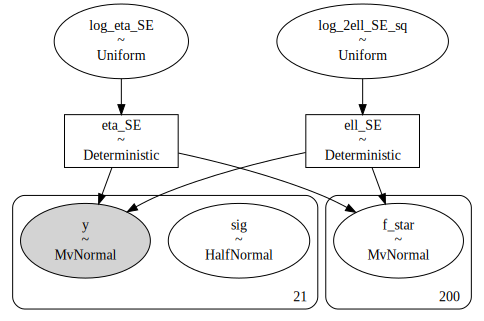

In [4]:
se_trace_path = Path(f"traces/{csv_path.stem}_se_idata.nc")
se_dag_path = Path(f'dags/{csv_path.stem}_se_dag.dot')

if se_trace_path.is_file():
    se_trace = az.from_netcdf(se_trace_path)
    se_dag = gv.Source.from_file(se_dag_path)
else:
    se_trace, se_dag = ufn.fit_se_gp(csv_path, rng_seed=rng);
    az.to_netcdf(se_trace, se_trace_path)
    with open(se_dag_path, 'w') as writehandle:
        writehandle.write(se_dag.source)

gv.Source(se_dag.source)

In [5]:
variable_names = ["log_2ell_SE_sq", "log_eta_SE", "ell_SE", "eta_SE"]
ufn.print_post_summary(se_trace_path, variable_names)

median       mad    eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq   5.708939  0.071848   5.598054   5.808080     0.002324   
log_eta_SE      -1.980095  0.133245  -2.164196  -1.775397     0.003782   
ell_SE          12.279068  0.441453  11.616815  12.903084     0.014265   
eta_SE           0.138056  0.018314   0.114842   0.169416     0.000522   

                 ess_median     ess_tail     r_hat       mean        sd  
log_2ell_SE_sq  3751.110751  1980.167805  1.001401   5.702558  0.109079  
log_eta_SE      4178.916321  2846.672813  1.000353  -1.968846  0.196232  
ell_SE          3751.110751  1980.167805  1.001412  12.258045  0.662219  
eta_SE          4178.916321  2846.672813  1.000094   0.142401  0.029312

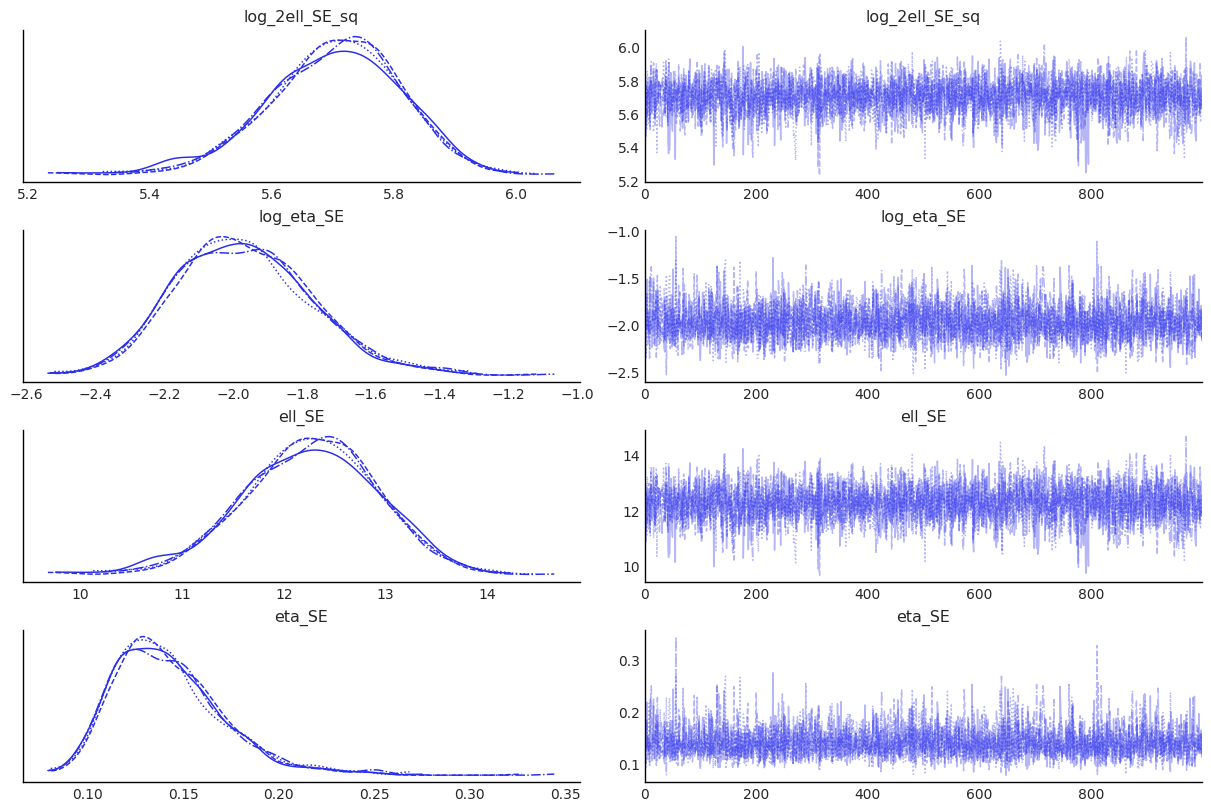

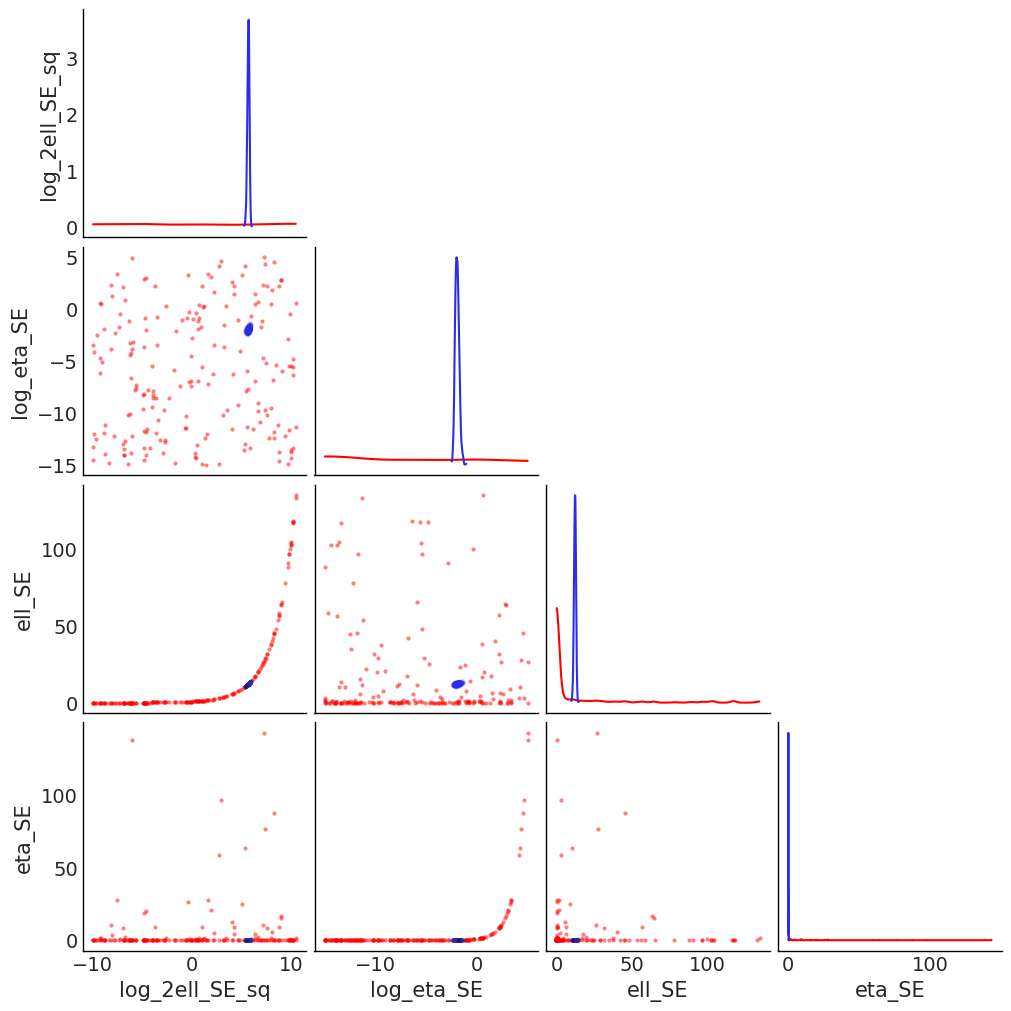

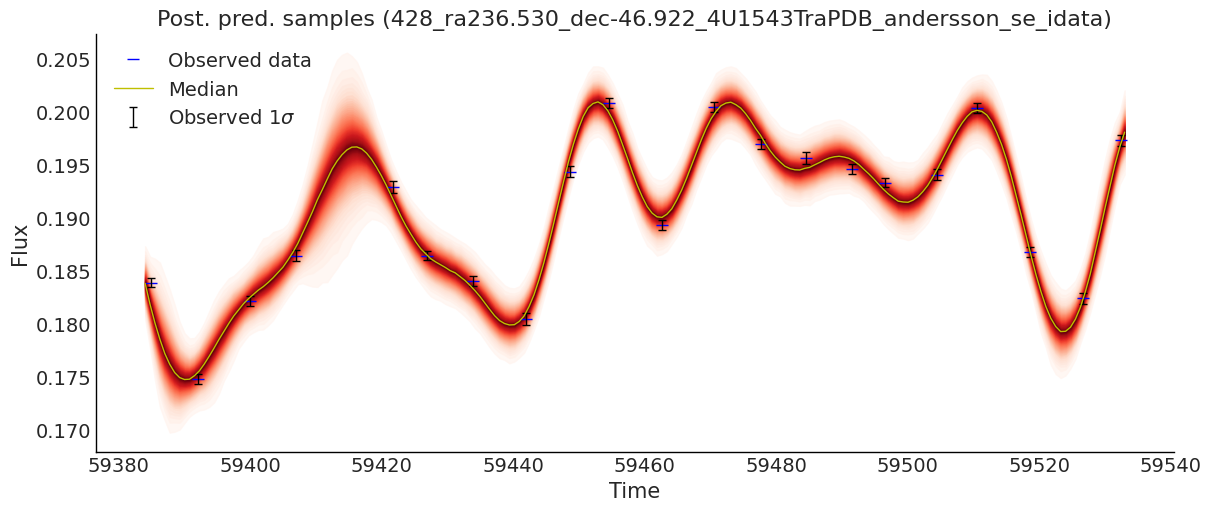

In [6]:
ufn.plot_traces(se_trace_path, variable_names)
ufn.plot_priorpost_cnr(se_trace_path, variable_names)
ufn.plot_postpred_samples(se_trace_path, csv_path)

## Matern $\frac{3}{2}$ Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{M}(\tau) =  \eta_\textrm{M}^2\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

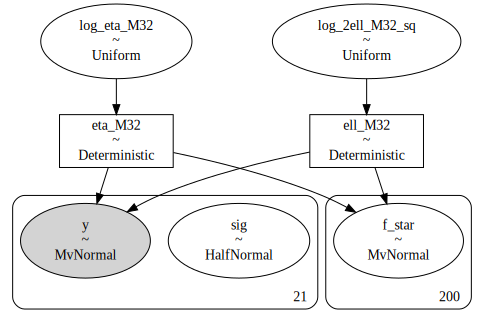

In [7]:
m32_trace_path = Path(f"traces/{csv_path.stem}_m32_idata.nc")
m32_dag_path = Path(f'dags/{csv_path.stem}_m32_dag.dot')

if m32_trace_path.is_file():
    m32_trace = az.from_netcdf(m32_trace_path)
    m32_dag = gv.Source.from_file(m32_dag_path)
else:
    m32_trace, m32_dag = ufn.fit_m32_gp(csv_path, rng_seed=rng);
    az.to_netcdf(m32_trace, m32_trace_path)
    with open(m32_dag_path, 'w') as writehandle:
        writehandle.write(m32_dag.source)

gv.Source(m32_dag.source)

In [8]:
variable_names = ["log_2ell_M32_sq", "log_eta_M32", "ell_M32", "eta_M32"]
ufn.print_post_summary(m32_trace_path, variable_names)

median        mad    eti_16%     eti_84%  mcse_median  \
log_2ell_M32_sq   9.834871   0.365168   9.316024   10.353546     0.012918   
log_eta_M32      -1.709563   0.240396  -2.047850   -1.358761     0.008221   
ell_M32          96.627375  17.645948  74.547624  125.235910     0.623724   
eta_M32           0.180945   0.041982   0.129012    0.256979     0.001484   

                  ess_median     ess_tail     r_hat       mean         sd  
log_2ell_M32_sq  2377.209350  1144.143731  0.999946   9.825120   0.480296  
log_eta_M32      2184.708502  2541.114901  1.000343  -1.706408   0.333698  
ell_M32          2377.209350  1144.143731  0.999946  98.912683  23.205902  
eta_M32          2184.708502  2541.114901  0.999933   0.191927   0.065443

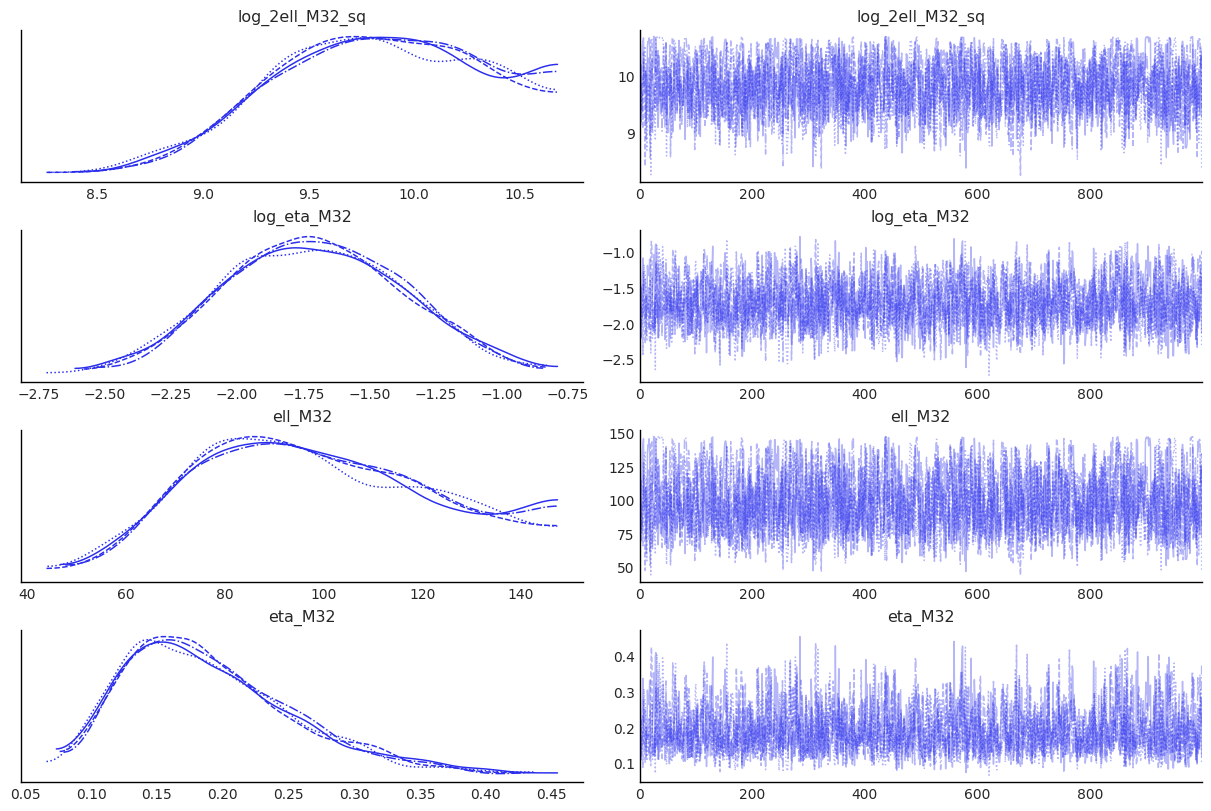

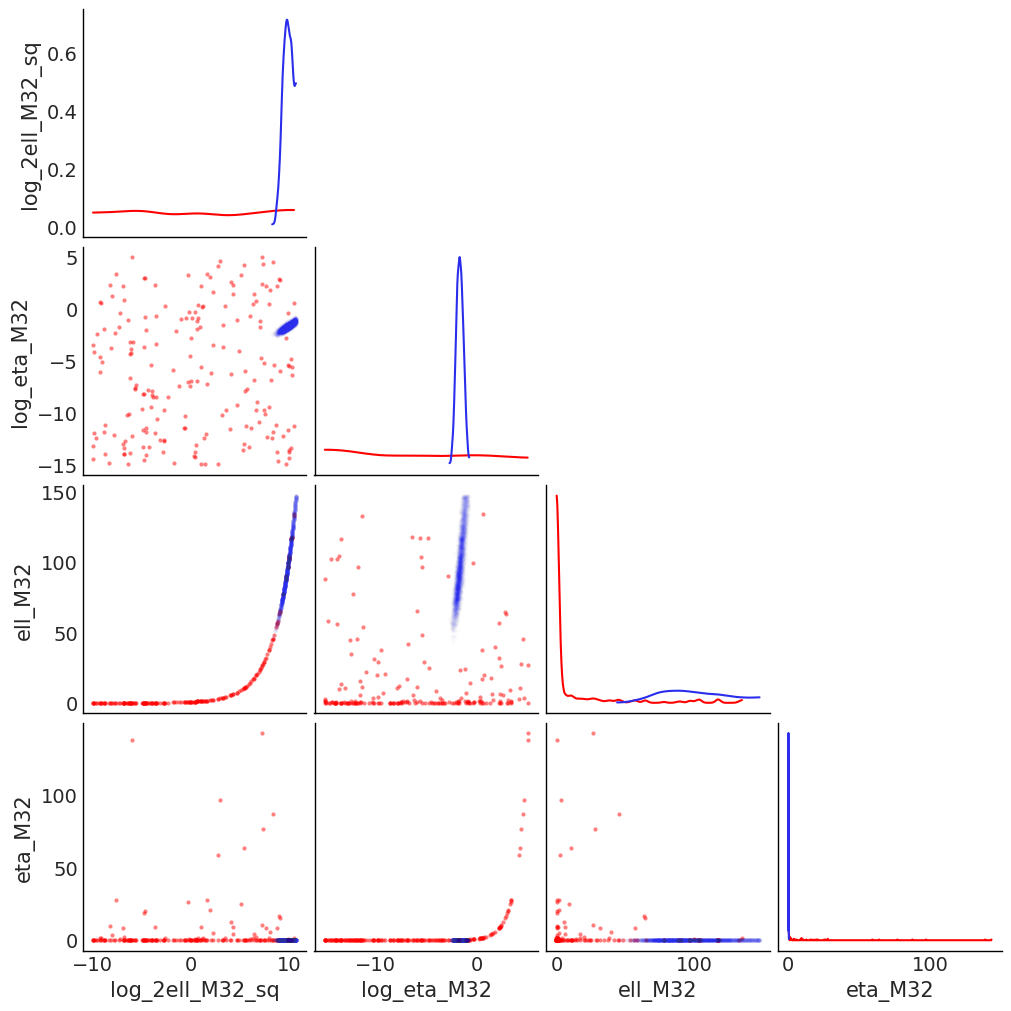

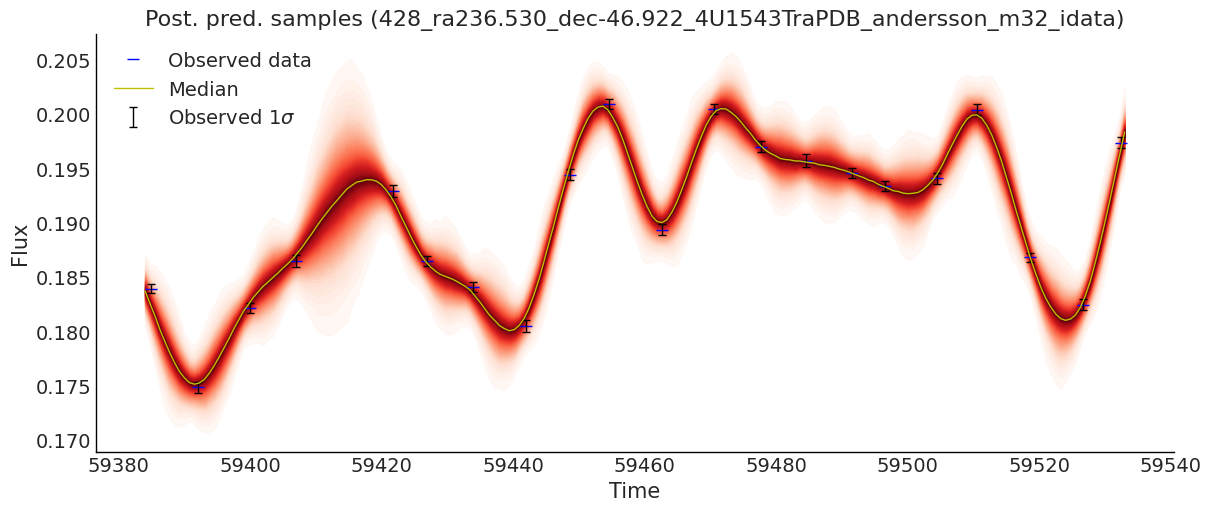

In [9]:
ufn.plot_traces(m32_trace_path, variable_names)
ufn.plot_priorpost_cnr(m32_trace_path, variable_names)
ufn.plot_postpred_samples(m32_trace_path, csv_path)

## SE + Matern $\frac{3}{2}$ additive kernel

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE+M}(\tau))$$

$$k_\textrm{SE+M}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} + \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

Sampling: [log_2ell_M_sq, log_2ell_SE_sq, log_eta_M, log_eta_SE, sig, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, log_2ell_M_sq, log_eta_M, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 387 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f_star]


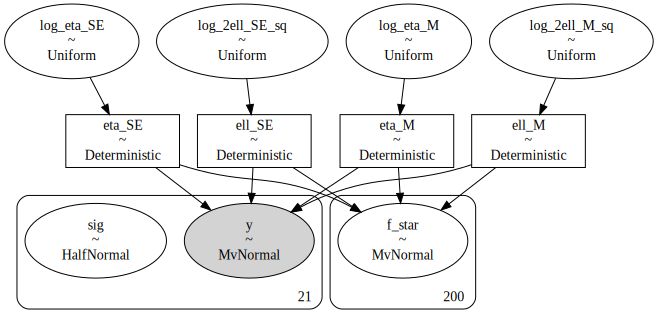

In [10]:
sem32_trace_path = Path(f"traces/{csv_path.stem}_se+m32_idata.nc")
sem32_dag_path = Path(f'dags/{csv_path.stem}_se+m32_dag.dot')

if sem32_trace_path.is_file():
    sem32_trace = az.from_netcdf(sem32_trace_path)
    sem32_dag = gv.Source.from_file(sem32_dag_path)
else:
    sem32_trace, sem32_dag = ufn.fit_sem32_gp(csv_path, multiplicative_kernel=False, rng_seed=rng);
    az.to_netcdf(sem32_trace, sem32_trace_path)
    with open(sem32_dag_path, 'w') as writehandle:
        writehandle.write(sem32_dag.source)

gv.Source(sem32_dag.source)

In [11]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta_SE", "log_eta_M"]
ufn.print_post_summary(sem32_trace_path, variable_names)

median       mad   eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq  10.381720  0.211541  9.820598  10.606964     0.058493   
log_2ell_M_sq   -1.833819  4.071718 -7.440396   3.712296     1.093522   
log_eta_SE      -2.097548  0.279429 -2.531282  -1.664799     0.066590   
log_eta_M       -5.104093  0.153479 -5.304342  -4.800348     0.033452   

                ess_median   ess_tail     r_hat      mean        sd  
log_2ell_SE_sq   57.907902  10.884389  1.155432  9.249682  3.792654  
log_2ell_M_sq    56.828837  10.866305  1.173855 -1.406361  5.595242  
log_eta_SE       61.999121  10.731813  1.157830 -2.380979  1.369269  
log_eta_M        56.345047  12.372706  1.163815 -4.822040  0.908662

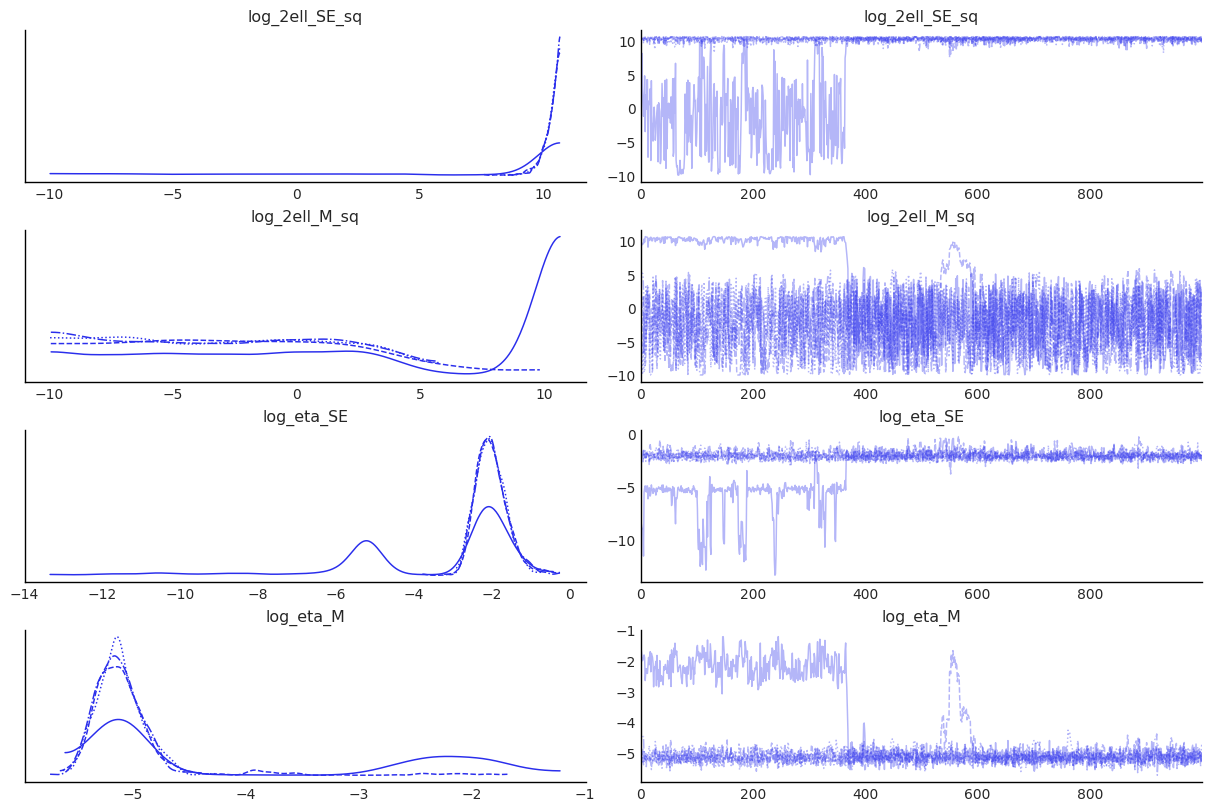

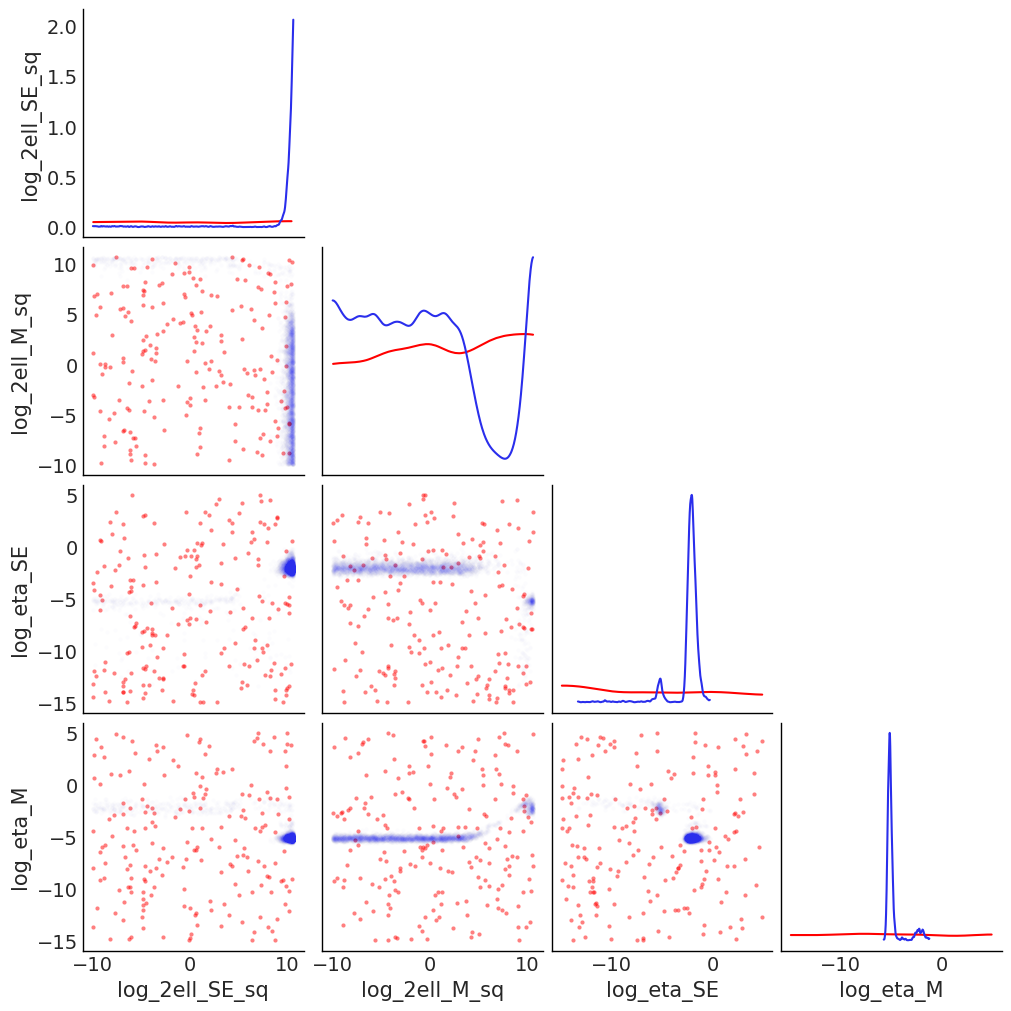

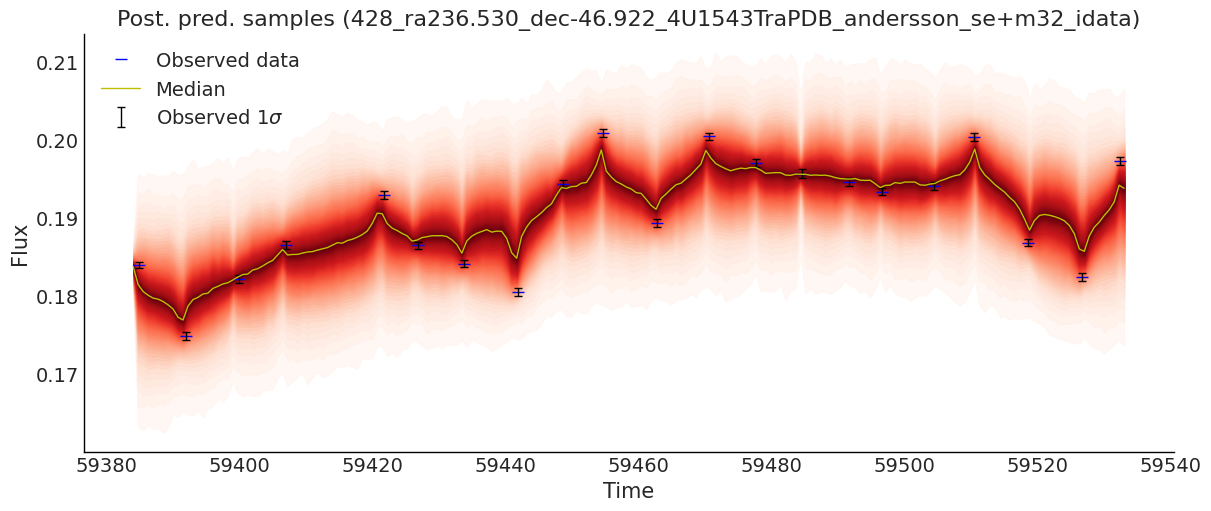

In [12]:
ufn.plot_traces(sem32_trace_path, variable_names)
ufn.plot_priorpost_cnr(sem32_trace_path, variable_names)
ufn.plot_postpred_samples(sem32_trace_path, csv_path)

## SE GP + Matern $\frac{3}{2}$ GP

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}, \quad k_\textrm{M}(\tau) = \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

Sampling: [log_2ell_M_sq, log_2ell_SE_sq, log_eta_M, log_eta_SE, sig, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, log_2ell_M_sq, log_eta_M, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 340 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f_star]


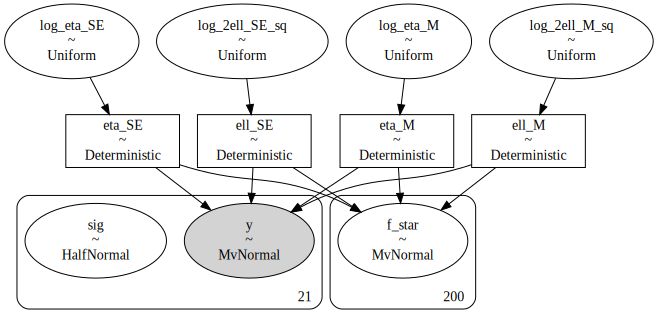

In [13]:
gpSE_gpM32_trace_path = Path(f"traces/{csv_path.stem}_gpSE_gpM32_idata.nc")
gpSE_gpM32_dag_path = Path(f'dags/{csv_path.stem}_gpSE_gpM32_dag.dot')

if gpSE_gpM32_trace_path.is_file():
    gpSE_gpM32_trace = az.from_netcdf(gpSE_gpM32_trace_path)
    gpSE_gpM32_dag = gv.Source.from_file(gpSE_gpM32_dag_path)
else:
    gpSE_gpM32_trace, gpSE_gpM32_dag = ufn.fit_sem32_gp(csv_path, multiplicative_kernel=False, rng_seed=rng);
    az.to_netcdf(gpSE_gpM32_trace, gpSE_gpM32_trace_path)
    with open(gpSE_gpM32_dag_path, 'w') as writehandle:
        writehandle.write(gpSE_gpM32_dag.source)

gv.Source(gpSE_gpM32_dag.source)

In [16]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta_SE", "log_eta_M"]
ufn.print_post_summary(gpSE_gpM32_trace_path, variable_names)

median       mad    eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq  10.397173  0.184117  10.004785  10.605470     0.008474   
log_2ell_M_sq   -2.634743  3.798141  -7.666387   2.620507     0.190689   
log_eta_SE      -2.053507  0.252350  -2.386087  -1.619325     0.008374   
log_eta_M       -5.131842  0.126498  -5.308647  -4.911575     0.006770   

                 ess_median     ess_tail     r_hat       mean        sd  
log_2ell_SE_sq  2280.316212  1052.286356  1.003270  10.312406  0.317210  
log_2ell_M_sq   1263.521468    37.181691  1.028775  -2.465920  4.528273  
log_eta_SE      3330.596675  1586.311847  1.000793  -2.007306  0.401842  
log_eta_M       1401.464977    35.739248  1.032773  -5.081082  0.321463

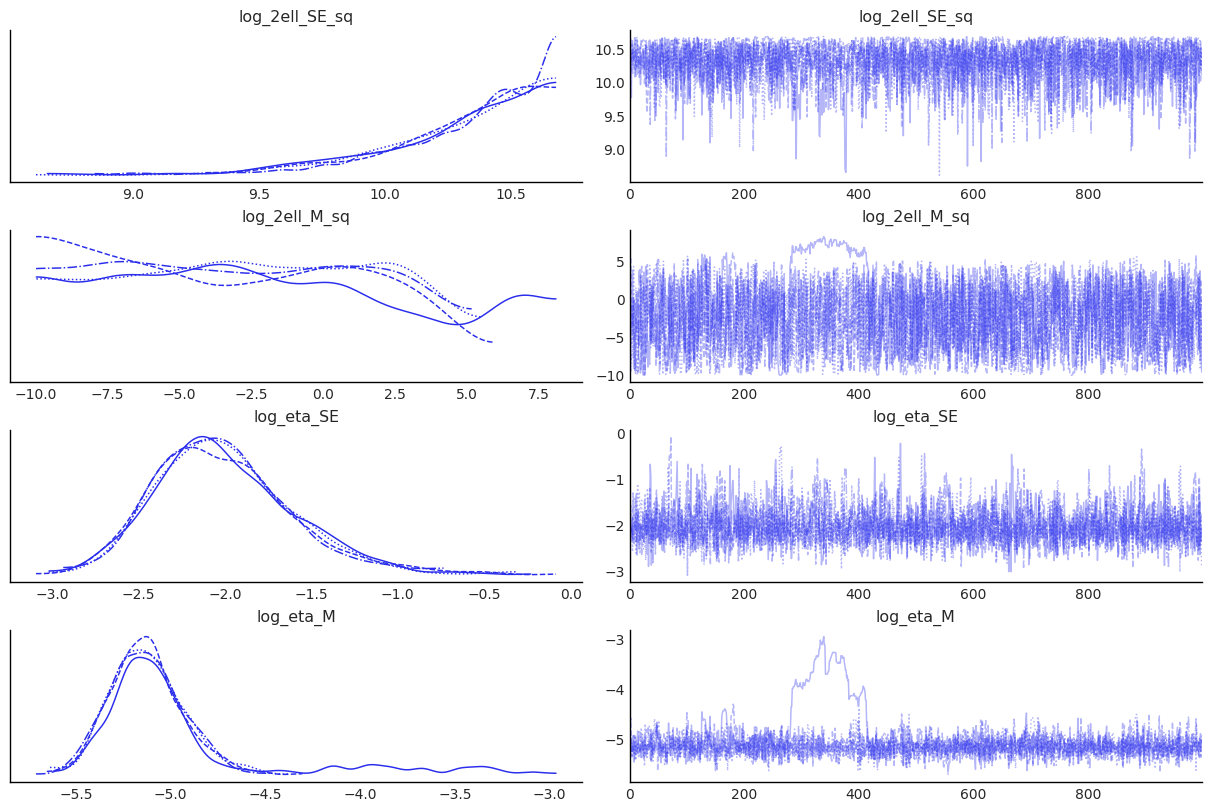

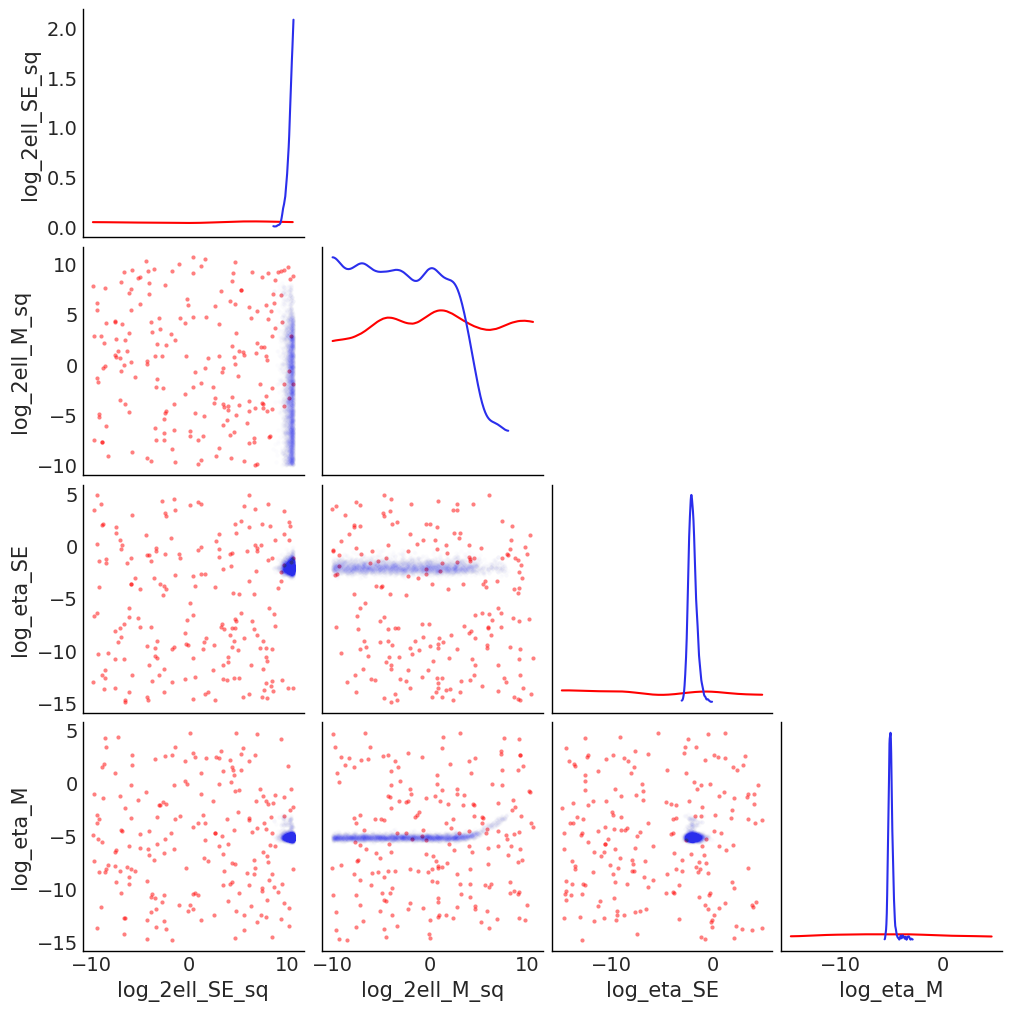

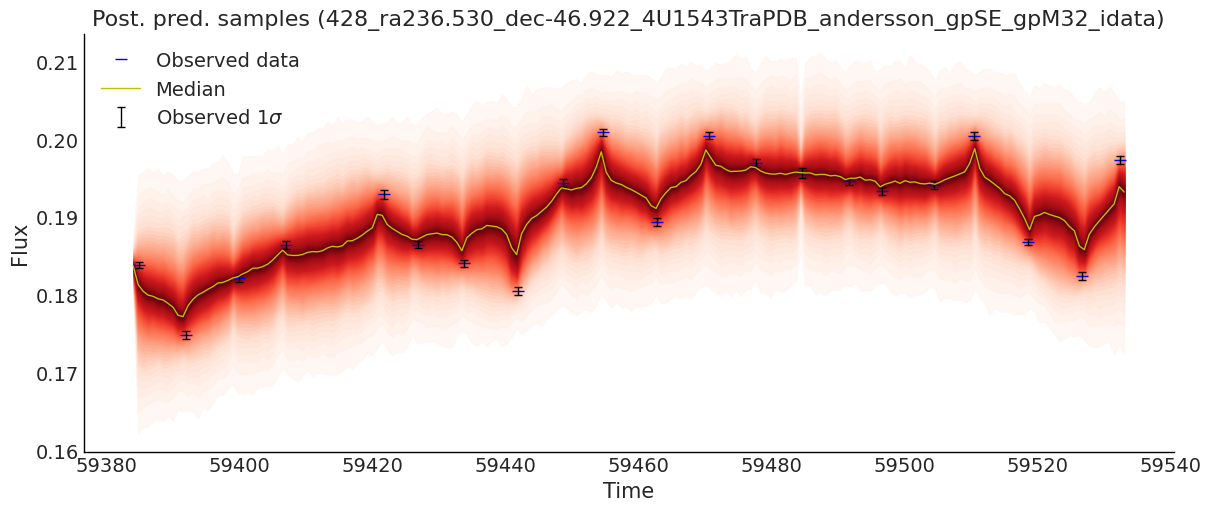

In [17]:
ufn.plot_traces(gpSE_gpM32_trace_path, variable_names)
ufn.plot_priorpost_cnr(gpSE_gpM32_trace_path, variable_names)
ufn.plot_postpred_samples(gpSE_gpM32_trace_path, csv_path)

## SE $\times$ Matern $\frac{3}{2}$ Multiplicative Kernel

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\mathrm{SE \times M}(\tau))$$

$$k_\mathrm{SE \times M}(\tau) = \eta^2\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} \left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta \sim \mathcal{U}[-15, 5]$$


$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

Sampling: [log_2ell_M_sq, log_2ell_SE_sq, log_eta, sig, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_2ell_M_sq, log_eta, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.
Sampling: [f_star]


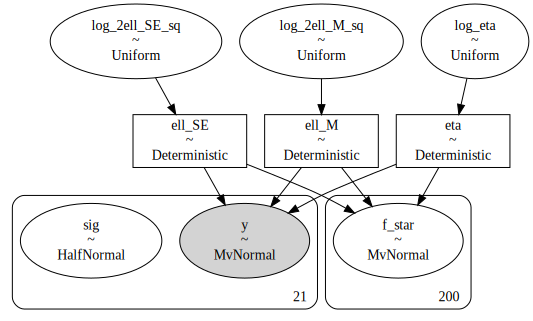

In [21]:
sexm32_trace_path = Path(f"traces/{csv_path.stem}_sexm32_idata.nc")
sexm32_dag_path = Path(f'dags/{csv_path.stem}_sexm32_dag.dot')

if sexm32_trace_path.is_file():
    sexm32_trace = az.from_netcdf(sexm32_trace_path)
    sexm32_dag = gv.Source.from_file(sexm32_dag_path)
else:
    sexm32_trace, sexm32_dag = ufn.fit_sem32_gp(csv_path, multiplicative_kernel=True, rng_seed=rng);
    az.to_netcdf(sexm32_trace, sexm32_trace_path)
    with open(sexm32_dag_path, 'w') as writehandle:
        writehandle.write(sexm32_dag.source)

gv.Source(sexm32_dag.source)

In [23]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta"]
ufn.print_post_summary(sexm32_trace_path, variable_names)

median       mad   eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq  10.008214  0.410638  9.277491  10.481732     0.017555   
log_2ell_M_sq    9.760726  0.356275  9.259651  10.273340     0.009777   
log_eta         -1.761879  0.233277 -2.069257  -1.405472     0.007234   

                 ess_median     ess_tail     r_hat      mean        sd  
log_2ell_SE_sq  3070.926250  1503.063449  1.001324  9.889859  0.586293  
log_2ell_M_sq   2983.114932  1674.870342  1.000661  9.752121  0.477571  
log_eta         2934.085162  2533.932088  1.001048 -1.741805  0.323033

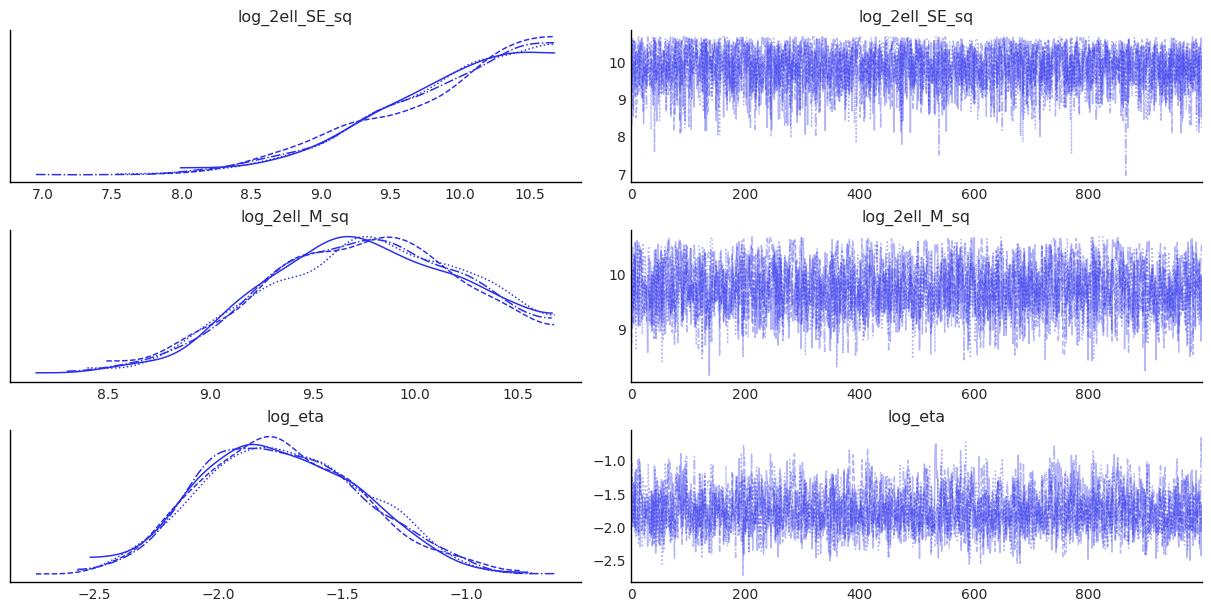

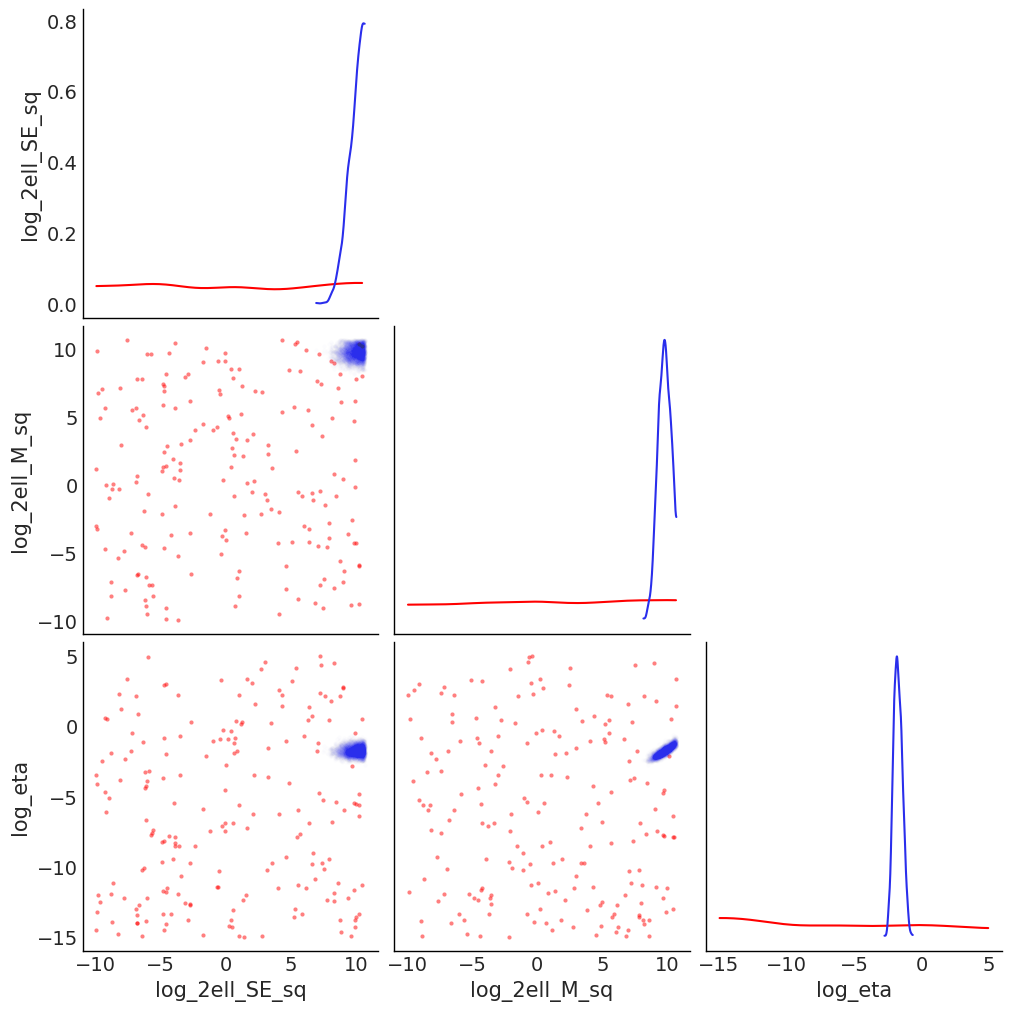

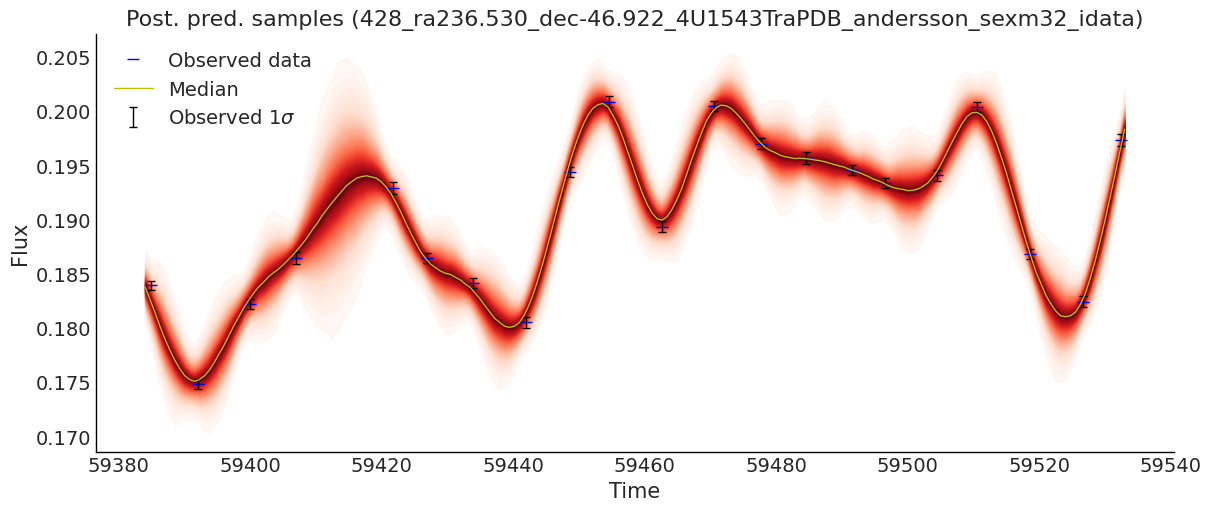

In [24]:
ufn.plot_traces(sexm32_trace_path, variable_names)
ufn.plot_priorpost_cnr(sexm32_trace_path, variable_names)
ufn.plot_postpred_samples(sexm32_trace_path, csv_path)